Phase 1: Dataset Preparation

In [ ]:
# Import libraries
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('health_data.csv')

# Basic inspection
print(df.head())
print(df.info())

# Convert age from days to years
df['age_years'] = df['age'] // 365

# Drop old age column if needed
df.drop('age', axis=1, inplace=True)

# Encode categorical variables
df['gender'] = df['gender'].replace({1: 0, 2: 1})  # 0: Female, 1: Male
cat_cols = ['cholesterol', 'gluc']
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes

# Remove duplicates and handle missing values
df = df.drop_duplicates()
df = df.dropna()


   Unnamed: 0   id      age  gender  height  weight  ap_hi  ap_lo  \
0           0  0.0  18393.0       1   168.0    62.0  110.0   80.0   
1           1  1.0  20228.0       0   156.0    85.0  140.0   90.0   
2           2  2.0  18857.0       0   165.0    64.0  130.0   70.0   
3           3  3.0  17623.0       1   169.0    82.0  150.0  100.0   
4           4  4.0  17474.0       0   156.0    56.0  100.0   60.0   

   cholesterol  gluc  smoke  alco  active  cardio  
0            0     0      0     0       1       0  
1            2     0      0     0       1       1  
2            2     0      0     0       0       1  
3            0     0      0     0       1       1  
4            0     0      0     0       0       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   70000 non-null  int64  
 1   id           70000 non-null  floa

Phase 2: Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Select features and target
features = ['age_years', 'height', 'weight', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
target = 'cardio'

# Scale numeric features
scaler = StandardScaler()
df[["height", "weight", "ap_hi", "ap_lo", "age_years"]] = scaler.fit_transform(df[["height", "weight", "ap_hi", "ap_lo", "age_years"]])

# Train-test split
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE if needed
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


Phase 3: Exploratory Data Analysis (EDA)

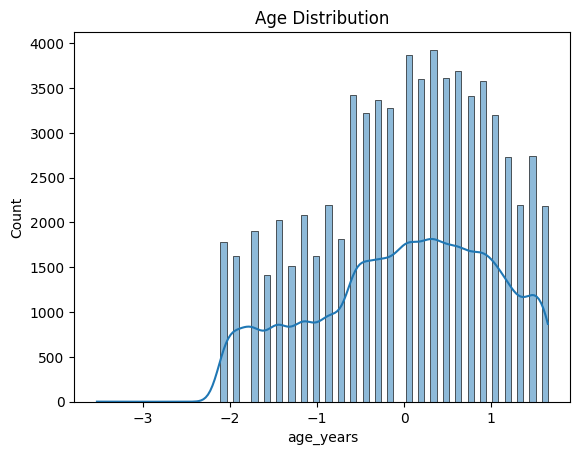

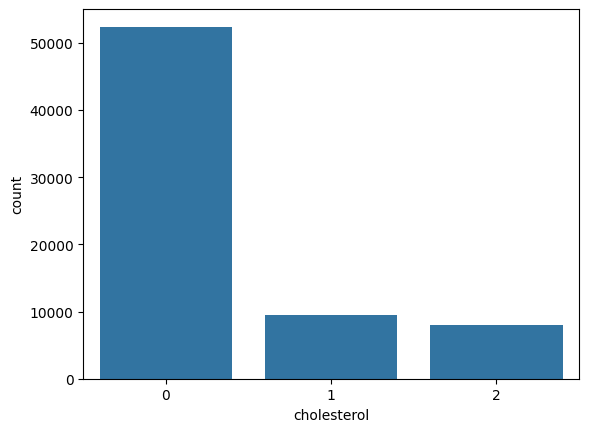

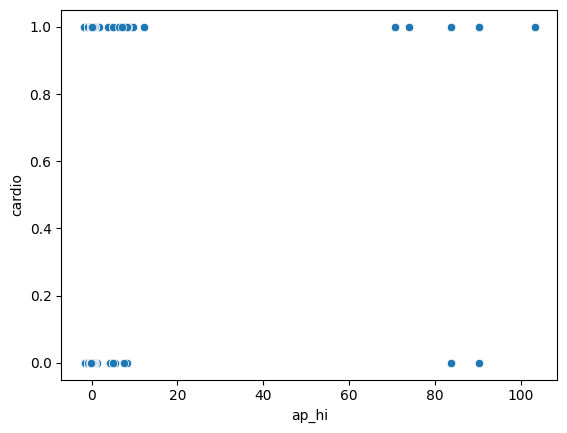

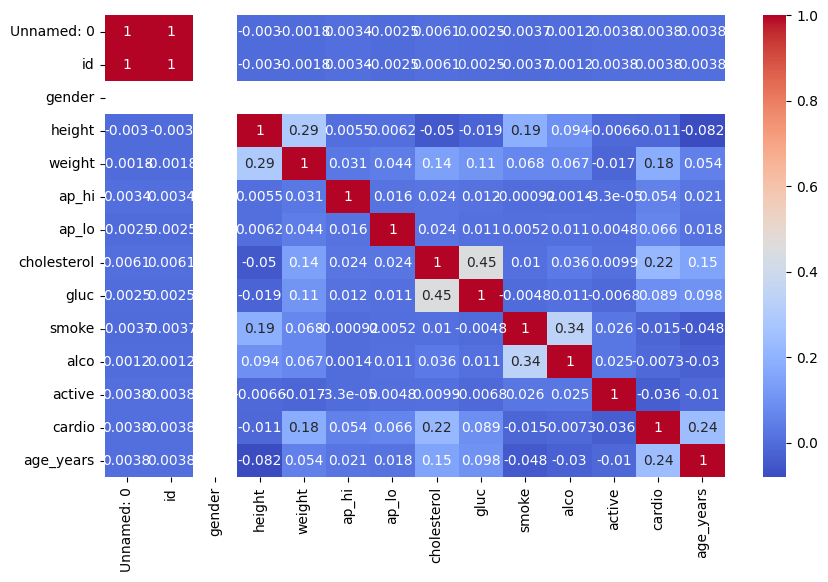

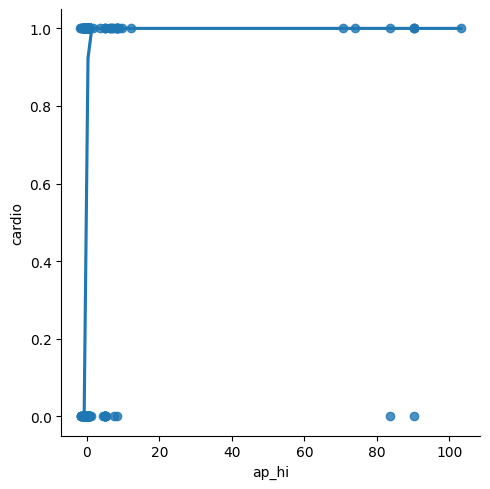

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution plots
sns.histplot(df['age_years'], kde=True)
plt.title('Age Distribution')
plt.show()

# Cholesterol, BP distributions
sns.countplot(x='cholesterol', data=df)
plt.show()

sns.scatterplot(x='ap_hi', y=target, data=df)
plt.show()

# Correlation heatmap
corr = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Pairwise scatter (for non-linear checks)
sns.lmplot(x='ap_hi', y=target, data=df, logistic=True)


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.4 MB/s eta 0:00:00


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier


Phase 4: Model Development

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Set up models
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(n_estimators=100, random_state=42)
lgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
tabnet = TabNetClassifier()

# Hyperparameter tuning (example GridSearch for RF)
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
grid = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

# Train models
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
mlp.fit(X_train, y_train)
tabnet.fit(X_train.values, y_train.values, eval_set=[(X_test.values, y_test.values)], patience=10)


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


[LightGBM] [Info] Number of positive: 28017, number of negative: 28017
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 56034, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
epoch 0  | loss: 0.62903 | val_0_auc: 0.7567  |  0:00:02s
epoch 1  | loss: 0.57024 | val_0_auc: 0.75156 |  0:00:05s
epoch 2  | loss: 0.56189 | val_0_auc: 0.7431  |  0:00:08s
epoch 3  | loss: 0.5587  | val_0_auc: 0.73524 |  0:00:11s
epoch 4  | loss: 0.55484 | val_0_auc: 0.7442  |  0:00:14s
epoch 5  | loss: 0.55429 | val_0_auc: 0.74689 |  0:00:16s
epoch 6  | loss: 0.55174 | val_0_auc: 0.74449 |  0:00:20s
epoch 7  | loss: 0.55306 | val_0_auc: 0.74841 |  0:00:22s
epoch 8  | loss: 0.55143 | val_0_a

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Phase 5: Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    metrics = {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1': f1_score(y_test, preds),
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    }
    return metrics

print('RF:', evaluate(rf, X_test, y_test))
print('XGB:', evaluate(xgb, X_test, y_test))
print('LGBM:', evaluate(lgbm, X_test, y_test))
print('MLP:', evaluate(mlp, X_test, y_test))
print('TabNet:', evaluate(tabnet, X_test.values, y_test.values))


RF: {'Accuracy': 0.7096428571428571, 'Precision': 0.7096266628522386, 'Recall': 0.7091194968553459, 'F1': 0.7093729892042611, 'AUC': np.float64(0.7622407182826834)}
XGB: {'Accuracy': 0.7312142857142857, 'Precision': 0.7475118664829276, 'Recall': 0.6978273299028016, 'F1': 0.7218156280032527, 'AUC': np.float64(0.7960947293370544)}
LGBM: {'Accuracy': 0.736, 'Precision': 0.75408068986757, 'Recall': 0.6999714122355631, 'F1': 0.7260192735359525, 'AUC': np.float64(0.7998868224120236)}
MLP: {'Accuracy': 0.7315, 'Precision': 0.7586702892760109, 'Recall': 0.6785305889079474, 'F1': 0.7163661057873689, 'AUC': np.float64(0.7960590864682731)}
TabNet: {'Accuracy': 0.7157857142857142, 'Precision': 0.7251828631138976, 'Recall': 0.694396798170383, 'F1': 0.709456005841548, 'AUC': np.float64(0.7721068133410003)}


Phase 6: Explainability & Feature Importance (SHAP)

In [ ]:
# Function to get input and predict
def get_patient_input():
    print("Enter patient details:")
    age_years = float(input('Age (years): '))
    height = float(input('Height (cm): '))
    weight = float(input('Weight (kg): '))
    gender = int(input('Gender (Female=0, Male=1): '))
    ap_hi = float(input('Systolic BP (ap_hi): '))
    ap_lo = float(input('Diastolic BP (ap_lo): '))
    cholesterol = int(input('Cholesterol (1: normal, 2: above normal, 3: well above normal): '))
    gluc = int(input('Glucose (1: normal, 2: above normal, 3: well above normal): '))
    smoke = int(input('Smoker (0: No, 1: Yes): '))
    alco = int(input('Alcohol intake (0: No, 1: Yes): '))
    active = int(input('Physically Active (0: No, 1: Yes): '))

    # Prepare input data
    data = {
        'age_years': age_years,
        'height': height,
        'weight': weight,
        'gender': gender,
        'ap_hi': ap_hi,
        'ap_lo': ap_lo,
        'cholesterol': cholesterol-1,  # If encoded as 0/1/2
        'gluc': gluc-1,  # If encoded as 0/1/2
        'smoke': smoke,
        'alco': alco,
        'active': active
    }
    input_df = pd.DataFrame([data])
    # If needed, normalize/scale:
    input_df[["height", "weight", "ap_hi", "ap_lo", "age_years"]] = scaler.transform(input_df[["height", "weight", "ap_hi", "ap_lo", "age_years"]])
    return input_df

# Get user input
user_input = get_patient_input()

# Predict with any trained model 'model' (rf, xgb, lgbm, mlp, etc.)

# Initial prediction and probability (for one sample)
pred_labels = rf.predict(user_input)
pred_probs = rf.predict_proba(user_input)

# Check shapes and get values safely
if len(pred_labels) == 1 and pred_probs.shape == (1, 2):
    prediction = int(pred_labels[0])
    prob = float(pred_probs[0][1])  # Probability of class 1 (CVD)
    print('Prediction (0: No CVD, 1: CVD):', prediction)
    print('Probability of CVD:', prob)
else:
    print("Shape mismatch! Check input formatting and model.")
    print(f"user_input shape: {user_input.shape}")
    print(f"pred_labels: {pred_labels}")
    print(f"pred_probs shape: {pred_probs.shape}")




Enter patient details:
Age (years): 55
Height (cm): 154
Weight (kg): 85
Gender (Female=0, Male=1): 0
Systolic BP (ap_hi): 140
Diastolic BP (ap_lo): 90
Cholesterol (1: normal, 2: above normal, 3: well above normal): 3
Glucose (1: normal, 2: above normal, 3: well above normal): 1
Smoker (0: No, 1: Yes): 0
Alcohol intake (0: No, 1: Yes): 0
Physically Active (0: No, 1: Yes): 1
Prediction (0: No CVD, 1: CVD): 1
Probability of CVD: 0.93


SHAP values shape: (1, 11, 2)
Top risk factors contributing to CVD:
 - ap_hi: value=0.07261016230221132, impact=0.1450
 - cholesterol: value=2.0, impact=0.1314
 - ap_lo: value=-0.03517998955018405, impact=0.0651
 - weight: value=0.7498311720670594, impact=0.0353
 - age_years: value=0.3191098307500176, impact=0.0157
 - height: value=-1.2617713914192663, impact=0.0149
 - gluc: value=0.0, impact=0.0085
 - active: value=1.0, impact=0.0077
 - smoke: value=0.0, impact=0.0041
 - alco: value=0.0, impact=0.0030


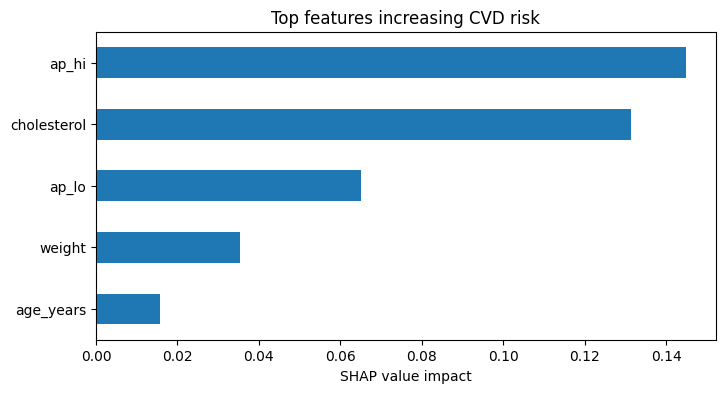

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(user_input)

print("SHAP values shape:", shap_values.shape)  # (1, 11, 2)

shap_vals_class1 = shap_values[0, :, 1]  # sample 0, all features, class 1

shap_series = pd.Series(shap_vals_class1, index=user_input.columns)

positive_impacts = shap_series[shap_series > 0].sort_values(ascending=False)

print("Top risk factors contributing to CVD:")
for feature, impact in positive_impacts.items():
    actual_val = user_input.iloc[0][feature]
    print(f" - {feature}: value={actual_val}, impact={impact:.4f}")

positive_impacts.head(5).plot(kind='barh', title='Top features increasing CVD risk', figsize=(8, 4))
plt.xlabel('SHAP value impact')
plt.gca().invert_yaxis()
plt.show()
